In [ ]:
! pip install langdetect

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
# from langdetect import detect
import pickle
import wordcloud
import re
from dateutil.parser import parse

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## **Reviews**

In [ ]:
reviews = []
iter=0
for line in open('/content/drive/My Drive/book_reviews/goodreads_reviews_fantasy_paranormal.json', 'r'):
  reviews.append(json.loads(line))
  if iter>100: break
  iter += 1

In [ ]:
reviews_df = pd.DataFrame.from_dict(reviews, orient='columns')

In [ ]:
reviews_df.to_pickle("/content/drive/My Drive/reviews_df.pkl")

In [ ]:
reviews_df.loc[reviews_df.book_id == '24544486']

,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
8585,9f30590bdd5c8860cb36c8d02ab30fac,24544486,bb034931852a42155e3f07ad8d1d0cc5,4,"Avevo un po' ""snobbato"" questa saga, e adesso ...",Wed Mar 09 15:11:43 -0800 2016,Sun Mar 13 09:17:13 -0700 2016,Sun Mar 13 10:21:02 -0700 2016,Thu Mar 10 00:00:00 -0800 2016,4,4


In [ ]:
reviews_df[reviews_df.book_id.isin(russian_book_ids)].iloc[0]

user_id                          9f30590bdd5c8860cb36c8d02ab30fac
book_id                                                  24544486
review_id                        bb034931852a42155e3f07ad8d1d0cc5
rating                                                          4
review_text     Avevo un po' "snobbato" questa saga, e adesso ...
date_added                         Wed Mar 09 15:11:43 -0800 2016
date_updated                       Sun Mar 13 09:17:13 -0700 2016
read_at                            Sun Mar 13 10:21:02 -0700 2016
started_at                         Thu Mar 10 00:00:00 -0800 2016
n_votes                                                         4
n_comments                                                      4
Name: 8585, dtype: object

## **Book info**

In [ ]:
book_info = []
iter=0
for line in open('/content/drive/My Drive/book_reviews/goodreads_books_fantasy_paranormal.json', 'r'):
  book_info.append(json.loads(line))

In [ ]:
book_info_df = pd.DataFrame.from_dict(book_info, orient='columns')

## **EDA**

#### Contains total of 89 different languages of Books. Among them, many have very less books. Hence for the analysis purpose, only those which are more than 500 books are shown in the plots.


In [ ]:
reviews_df = pd.read_pickle("/content/drive/My Drive/reviews_df.pkl")

In [ ]:
lang_distribution = book_info_df.groupby("language_code").count()[["book_id"]].reset_index()
lang_distribution.rename(columns={"book_id": "num_books"}, inplace=True)
lang_distribution.sort_values("num_books").reset_index(drop=True)

lang_distribution = lang_distribution.loc[lang_distribution.num_books >= 500]   # Filtering #books more than 500
lang_distribution

,language_code,num_books
0,,70664
14,bul,912
17,cze,1759
18,dan,551
21,en-CA,1724
22,en-GB,11171
23,en-US,15303
24,eng,119207
30,fin,853
31,fre,4097


The second largest count of book ids does not have any information on the languages

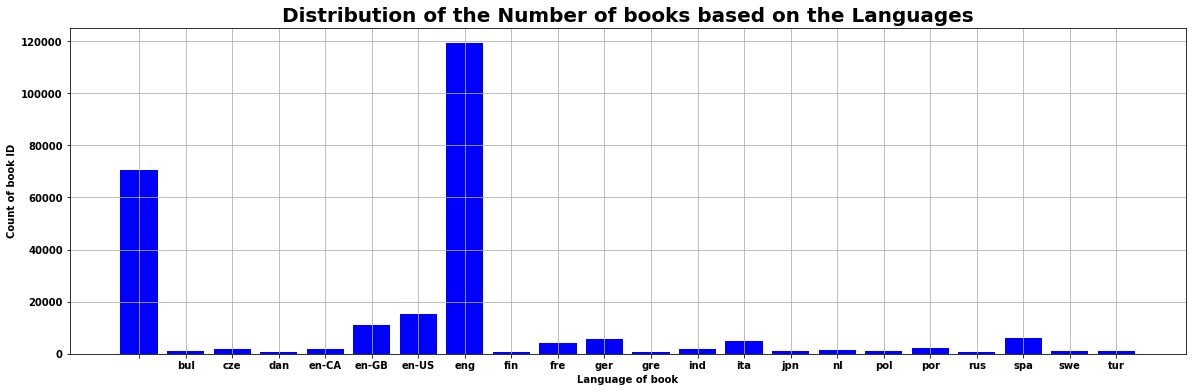

In [ ]:
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

plt.figure(figsize=(20, 6))
plt.bar(x=lang_distribution.language_code, height=lang_distribution.num_books, color="blue")
plt.grid("brown")
plt.title("Distribution of the Number of books based on the Languages", fontweight="bold", fontsize=20)
plt.xlabel("Language of book")
plt.ylabel("Count of book ID")
plt.show()

In [ ]:
unknown_lang = book_info_df.loc[book_info_df.language_code == ""].book_id.values
unknown_lang

array(['6066812', '12182387', '25742454', ..., '24784578', '7925060',
       '17397840'], dtype=object)

In [ ]:
## Checking which of them doesnot belong to English

unknown_lang_reviews = reviews_df[reviews_df.book_id.isin(unknown_lang)]
other_lang_book_ids = list()
for index, text in enumerate(unknown_lang_reviews.review_text):
  try:
    lang = detect(text)
    if lang != 'en': 
      other_lang_book_ids.append(unknown_lang_reviews.iloc[index].book_id)

  except Exception as e:
    pass

In [ ]:
## Saving book IDs that got classified as Non-English languages

with open("/content/drive/My Drive/other_lang_book_ids.txt", "wb") as fp:   #Pickling
  pickle.dump(other_lang_book_ids, fp)

In [ ]:
## Loading pickle file

with open("/content/drive/My Drive/other_lang_book_ids.txt", "rb") as fp:   #UnPickling
  other_lang_book_ids = pickle.load(fp)

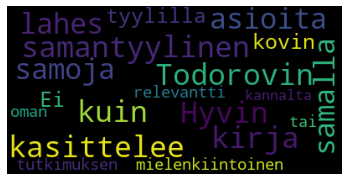

In [ ]:
## Example of the Reviews classified as Non-english - WORDCLOUD representation

wc = wordcloud.WordCloud(background_color='black', max_words=100, 
                         max_font_size=35)
wc = wc.generate(reviews_df.loc[reviews_df.book_id == other_lang_book_ids[1]].review_text.values[0])
fig = plt.figure(num=1)
plt.axis('off')
plt.imshow(wc, cmap=None)
plt.show()

### Hence, the Book IDs classified as English, are merged into the assigned 'en' to the 'language_code'

In [ ]:
### Removing duplicates 
other_lang_book_ids = set(other_lang_book_ids)
print('% of books classified as other languages from unknown language code = {}%'.format(np.round(len(other_lang_book_ids) / len(unknown_lang) * 100, 2)))  
# These 4.6% of the revires are being removed and rest of them are considered as english reviews which is equal to 3256 reviews out of 70664 reviews.

% of books classified as other languages from unknown language code = 4.58%


In [ ]:
eng_classified_book_ids = pd.Series(unknown_lang)[~(pd.Series(unknown_lang).isin(other_lang_book_ids))].values

In [ ]:
book_info_df.loc[book_info_df.book_id.isin(eng_classified_book_ids), 'language_code'] = 'english_merged'   # naming 'language_code' as 'english_merged'

## Renaming 'eng', 'en-US' and 'en-GB', 'en-CA' as 'english_merged'.
other_english_book_ids = book_info_df.loc[(book_info_df.language_code=='eng') | (book_info_df.language_code=='en-US')
                                          |(book_info_df.language_code=='en-GB')|(book_info_df.language_code=='en-CA')].book_id.values

book_info_df.loc[book_info_df.book_id.isin(other_english_book_ids), 'language_code'] = 'english_merged'

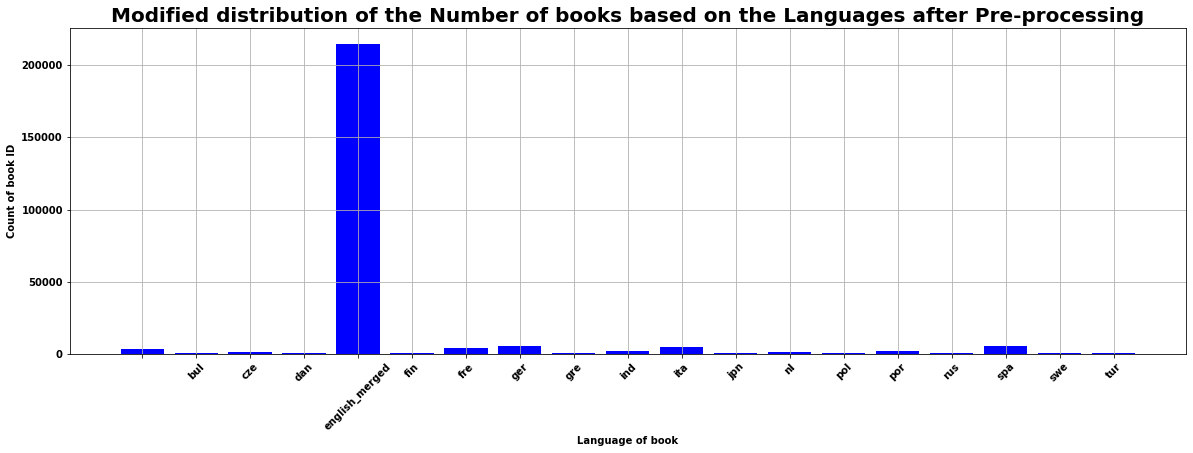

In [ ]:
new_lang_distribution = book_info_df.groupby("language_code").count()[["book_id"]].reset_index()
new_lang_distribution.rename(columns={"book_id": "num_books"}, inplace=True)
new_lang_distribution.sort_values("num_books").reset_index(drop=True)

new_lang_distribution = new_lang_distribution.loc[new_lang_distribution.num_books >= 500]   # Filtering #books more than 500



plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

plt.figure(figsize=(20, 6))
plt.bar(x=new_lang_distribution.language_code, height=new_lang_distribution.num_books, color="blue")
plt.grid("brown")
plt.title("Modified distribution of the Number of books based on the Languages after Pre-processing", fontweight="bold", fontsize=20)
plt.xlabel("Language of book")
plt.ylabel("Count of book ID")
plt.xticks(rotation=45)
plt.show()

In [ ]:
## Now other language reviews and books are discarded and the book IDs from "english_merged" are considered for the analysis

total_english_book_ids = book_info_df.loc[(book_info_df.language_code=='english_merged')].book_id.values
book_info_df = book_info_df.loc[(book_info_df.book_id.isin(total_english_book_ids))]

In [ ]:
english_filtered_book_ids = book_info_df.book_id.unique()

In [ ]:
## Saving book IDs that got classified as Non-English languages

with open("/content/drive/My Drive/english_filtered_book_ids.txt", "wb") as fp:   #Pickling
  pickle.dump(english_filtered_book_ids, fp)

In [ ]:
book_info_df.shape

(214831, 29)

### **Number of books based on pubishers**

In [ ]:
book_info = []
iter=0
for line in open('/content/drive/My Drive/book_reviews/goodreads_books_fantasy_paranormal.json', 'r'):
  book_info.append(json.loads(line))
  
book_info_df = pd.DataFrame.from_dict(book_info, orient='columns')



## Loading pickle file

with open("/content/drive/My Drive/english_filtered_book_ids.txt", "rb") as fp:   #UnPickling
  english_filtered_book_ids = pickle.load(fp)

book_info_df = book_info_df.loc[book_info_df.book_id.isin(english_filtered_book_ids)]
del (book_info)
book_info_df["language_code"] = "english_merged"

In [ ]:
book_info_df.isbn.unique()

array(['', '1934876569', '0698143760', ..., '1447273265', '1619218909',
       '1475973500'], dtype=object)

In [ ]:
book_info_df.loc[book_info_df.publisher=='', 'publisher'] = "UNKNOWN"

In [ ]:
publisher_distribution = book_info_df.groupby("publisher").count()[["book_id"]].reset_index()
publisher_distribution.rename(columns={"book_id": "num_books"}, inplace=True)
publisher_distribution.sort_values("num_books").reset_index(drop=True)

,publisher,num_books
0,"""Ace""",1
1,Metamor Studios,1
2,Metamuse Media,1
3,Methuen & Co. Ltd. London,1
4,Methuen Co Ltd,1
...,...,...
20774,HarperCollins,1605
20775,Smashwords Edition,1836
20776,Tor Books,2145
20777,Createspace Independent Publishing Platform,2159


In [ ]:
## Considering publishers having more than 100 books
publisher_distribution = publisher_distribution.loc[publisher_distribution.num_books>100]

In [ ]:
publisher_distribution

,publisher,num_books
60,47North,208
268,AO3,398
364,Ace,1367
374,Ace Books,459
545,Aladdin,318
...,...,...
20226,Yen On,131
20227,Yen Press,429
20276,Zebra,306
20467,eXtasy Books,249


In [ ]:
publisher_distribution['publisher_acronym'] = publisher_distribution.publisher.str.slice(0,7)
publisher_distribution

,publisher,num_books,publisher_acronym
60,47North,208,47North
268,AO3,398,AO3
364,Ace,1367,Ace
374,Ace Books,459,Ace Boo
545,Aladdin,318,Aladdin
...,...,...,...
20226,Yen On,131,Yen On
20227,Yen Press,429,Yen Pre
20276,Zebra,306,Zebra
20467,eXtasy Books,249,eXtasy


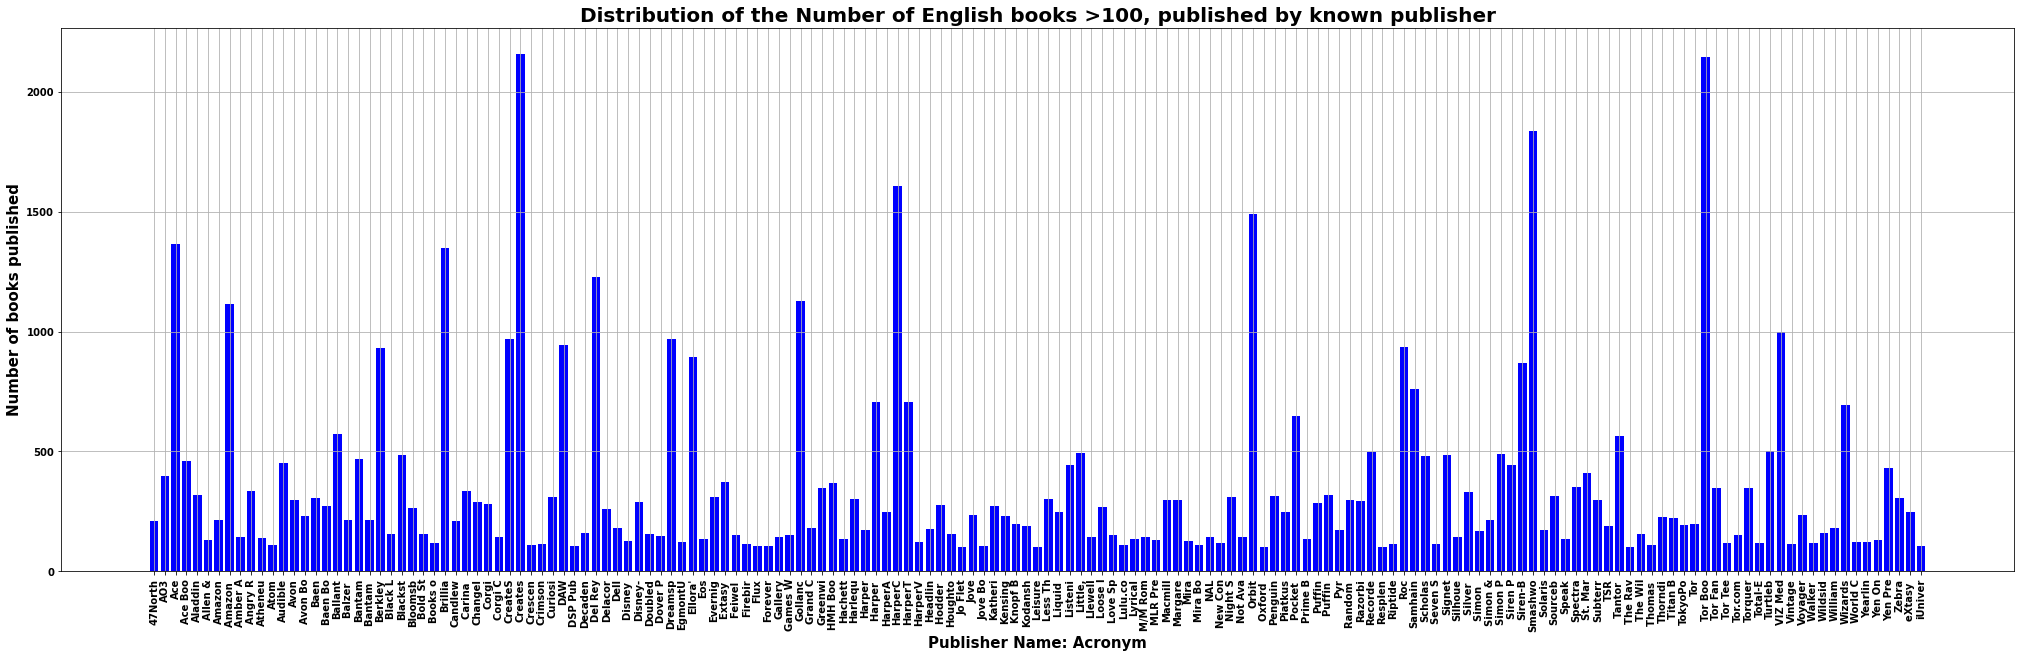

In [ ]:
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

plt.figure(figsize=(35, 10))
plt.bar(x=publisher_distribution.loc[publisher_distribution.publisher!="UNKNOWN"].publisher_acronym.values, height=publisher_distribution.loc[publisher_distribution.publisher!="UNKNOWN"].num_books.values, color="blue")
plt.grid("brown")
plt.title("Distribution of the Number of English books >100, published by known publisher", fontweight="bold", fontsize=20)
plt.xlabel("Publisher Name: Acronym", fontsize=15)
plt.ylabel("Number of books published", fontsize=15)
plt.xticks(rotation=90)
plt.show()

In [ ]:
publisher_distribution["is_publisher_available"] = "Known publisher"
publisher_distribution.loc[publisher_distribution.publisher=="UNKNOWN", "is_publisher_available"] = "Uknown publisher"
publisher_distribution.groupby("is_publisher_available").sum()[["num_books"]].reset_index()

,is_publisher_available,num_books
0,Known publisher,71791
1,Uknown publisher,68644


### **Percentage of Books having Known Publisher Info**

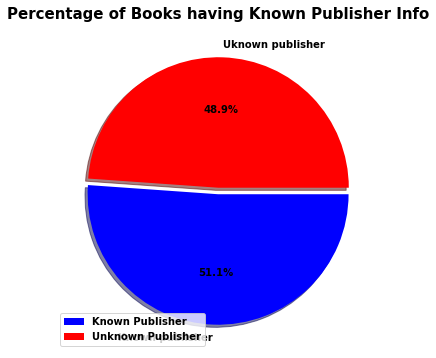

In [ ]:
### However, many english books publshed in Goodreads doesn't have any Publisher Info

plt.figure(figsize=(20, 6))
colors = ['b', 'r']
labels = ['Known Publisher', 'Unknown Publisher']
explode = (0.05, 0)

plt.pie(publisher_distribution.groupby("is_publisher_available").sum()[["num_books"]].reset_index().num_books, 
        labels = publisher_distribution.groupby("is_publisher_available").sum()[["num_books"]].reset_index().is_publisher_available.values,
        counterclock=False, shadow=True, colors = colors, autopct='%1.1f%%', explode=explode)
plt.legend(labels,loc=3)
plt.title("Percentage of Books having Known Publisher Info", fontweight="bold",fontsize=15)
plt.show()

### **Rating and Reviews distribution by the Users**

In [ ]:
reviews_df = pd.read_pickle("/content/drive/My Drive/reviews_df.pkl")

In [ ]:
## "read_at" has many missing entries. Hence, "date_added" is taken to extact year info so that we will get at which year the user read the book.

reviews_df["date_added_year"] = reviews_df.date_added.apply(lambda x: x[-4:])

In [ ]:
user_rating_info_df = reviews_df.loc[reviews_df.book_id.isin(book_info_df.book_id.values)].groupby(["user_id", "date_added_year"]).count()[["book_id"]].reset_index()
user_rating_info_df = user_rating_info_df.rename(columns={"book_id":"num_books_per_yr"})

## Now averaging based on year to get an average count of number of books read by each user on an yearly basis
user_rating_info_df = user_rating_info_df.groupby("user_id").mean()["num_books_per_yr"].reset_index().sort_values(by="num_books_per_yr", ascending=False)
user_rating_info_df

,user_id,num_books_per_yr
34604,907b410c80367c99a1a479aa24f021a2,464.333333
31647,843a44e2499ba9362b47a089b0b0ce75,312.777778
52460,db76c7e84e7da73efc7de2305ef3a3ed,295.500000
60495,fcf087290b8c3f96a442f858809bf6ef,226.500000
21314,59151b639f247aa97fffd5c71701db29,207.000000
...,...,...
12713,34d15cb248d496b9513a7ae42546affc,1.000000
39058,a323407b263626fc4309cbbdc9d2641b,1.000000
39056,a3229e60155fdf541295ebf1941ec2da,1.000000
39055,a32249099b27663f86575e487a614720,1.000000


In [ ]:
## Some users have shown that they read upto 300-400 books per year (POSSIBLY BOT)

num_book_grouping = user_rating_info_df.groupby("num_books_per_yr").count()["user_id"].reset_index().sort_values(by="num_books_per_yr", ascending=False)
num_book_grouping = num_book_grouping.rename(columns={"user_id" : "number_of_users"})
num_book_grouping

,num_books_per_yr,number_of_users
1201,464.333333,1
1200,312.777778,1
1199,295.500000,1
1198,226.500000,1
1197,207.000000,1
...,...,...
4,1.200000,96
3,1.166667,23
2,1.142857,3
1,1.125000,1


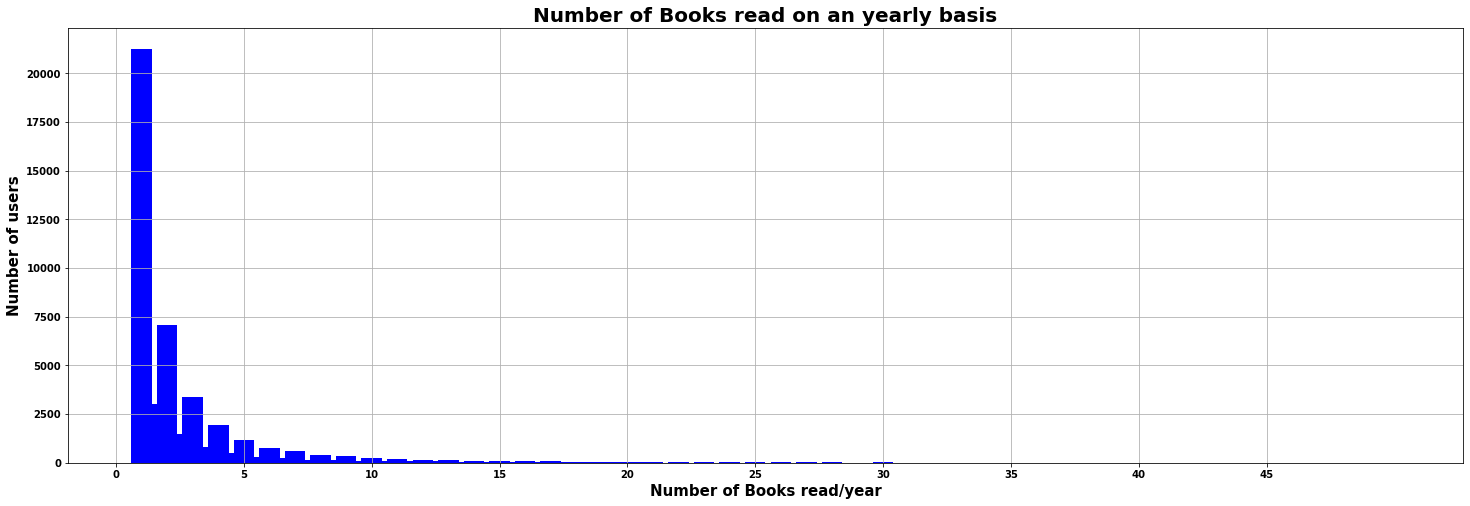

In [ ]:
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.figure(figsize=(25, 8))

plt.bar(x=num_book_grouping.loc[num_book_grouping.num_books_per_yr<50].num_books_per_yr.unique(), height=num_book_grouping.loc[num_book_grouping.num_books_per_yr<50].number_of_users, color="blue")
plt.title("Number of Books read on an yearly basis", fontweight="bold", fontsize=20)
plt.xlabel("Number of Books read/year", fontsize=15)
plt.ylabel("Number of users", fontsize=15)
plt.grid('brown')
plt.xticks(np.arange(0, 50, 5))
plt.show()

### **Distribution of the Ratio of In-frequent, Moderate and Frequent User ratings**

In [ ]:
## https://www.pewresearch.org/fact-tank/2015/10/19/slightly-fewer-americans-are-reading-print-books-new-survey-finds/
## The above link says that on an average, men read 9 and women read 14 book per year.
## Hence, if x>14 = frequent users, 9<x<14 = moderate users and x<9 = infrequent users.

num_book_grouping["user_type"] = num_book_grouping.num_books_per_yr.apply(lambda x: "infrequent" if x<9 else ("moderate" if ((x<14) and (x>9)) else "frequent"))
num_book_grouping = num_book_grouping.groupby("user_type").sum()["number_of_users"].reset_index()
num_book_grouping

,user_type,number_of_users
0,frequent,3309
1,infrequent,55347
2,moderate,2500


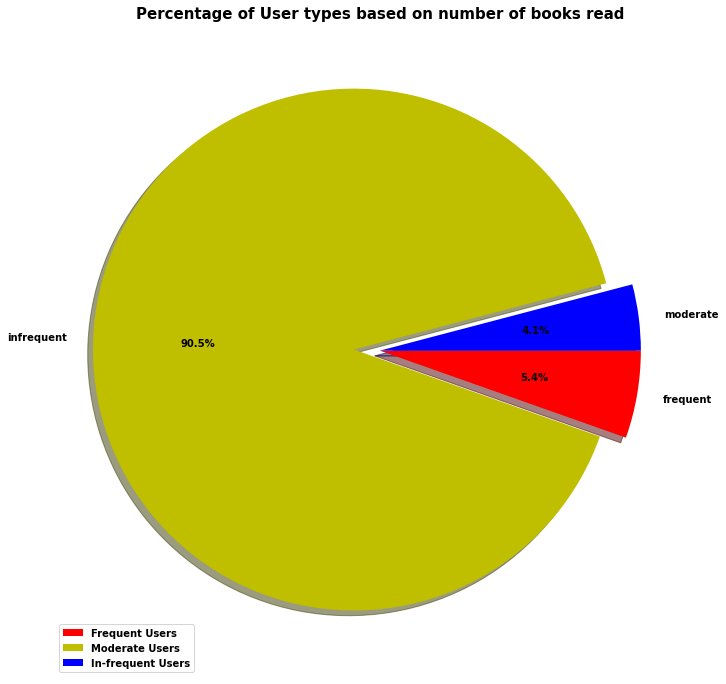

In [ ]:
plt.figure(figsize=(35, 12))
colors = ['r', 'y', 'b']
labels = ['Frequent Users', 'Moderate Users', 'In-frequent Users']
explode = (0, 0.1, 0)

plt.pie(num_book_grouping.groupby("user_type").sum()["number_of_users"].reset_index().number_of_users, 
        labels = num_book_grouping.groupby("user_type").sum()["number_of_users"].reset_index().user_type,
        counterclock=False, shadow=True, colors = colors, autopct='%1.1f%%', explode=explode)
plt.legend(labels,loc=3)
plt.title("Percentage of User types based on number of books read", fontweight="bold",fontsize=15)
plt.show()

## **Publisher Information**

In [ ]:
## Some missing data, wrong publication years are removed for the analysis

filtered_book_relevant_pub_year = book_info_df.loc[(book_info_df.publication_year!='')]
filtered_book_relevant_pub_year["pub_year_int"] = filtered_book_relevant_pub_year.publication_year.apply(lambda x: int(x))

filtered_book_relevant_pub_year = filtered_book_relevant_pub_year.loc[(filtered_book_relevant_pub_year.pub_year_int > 1000) & (filtered_book_relevant_pub_year.pub_year_int < 2021)]
filtered_book_relevant_pub_year.pub_year_int.unique()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


array([1014, 1017, 1197, 1384, 1391, 1812, 1825, 1845, 1850, 1859, 1866,
       1872, 1874, 1882, 1884, 1892, 1893, 1894, 1895, 1897, 1899, 1900,
       1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910, 1911,
       1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922,
       1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933,
       1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945,
       1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956,
       1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967,
       1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978,
       1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
       1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020])

In [ ]:
pubYear_bookFreq_info = filtered_book_relevant_pub_year.groupby("pub_year_int").count()["book_id"].reset_index().rename(columns={'book_id':"num_books"}).sort_values(by="pub_year_int")
pubYear_bookFreq_info

,pub_year_int,num_books
0,1014,1
1,1017,1
2,1197,1
3,1384,1
4,1391,1
...,...,...
136,2016,11328
137,2017,6525
138,2018,358
139,2019,45


In [ ]:
print ("Only {}% of the total books have relevant publishing year info among the total English books, which makes upto {} number of books with publish date".format(np.round(book_info_df.loc[(book_info_df.publication_year!='')].shape[0] / book_info_df.shape[0], 2) * 100, book_info_df.loc[(book_info_df.publication_year!='')].shape[0]))

Only 73.0% of the total books have relevant publishing year info among the total English books, which makes upto 156618 number of books with publish date


#### **Only 73% of the total books have relevant publishing year info among the total English books, which makes upto 156618  number of books with publish date**

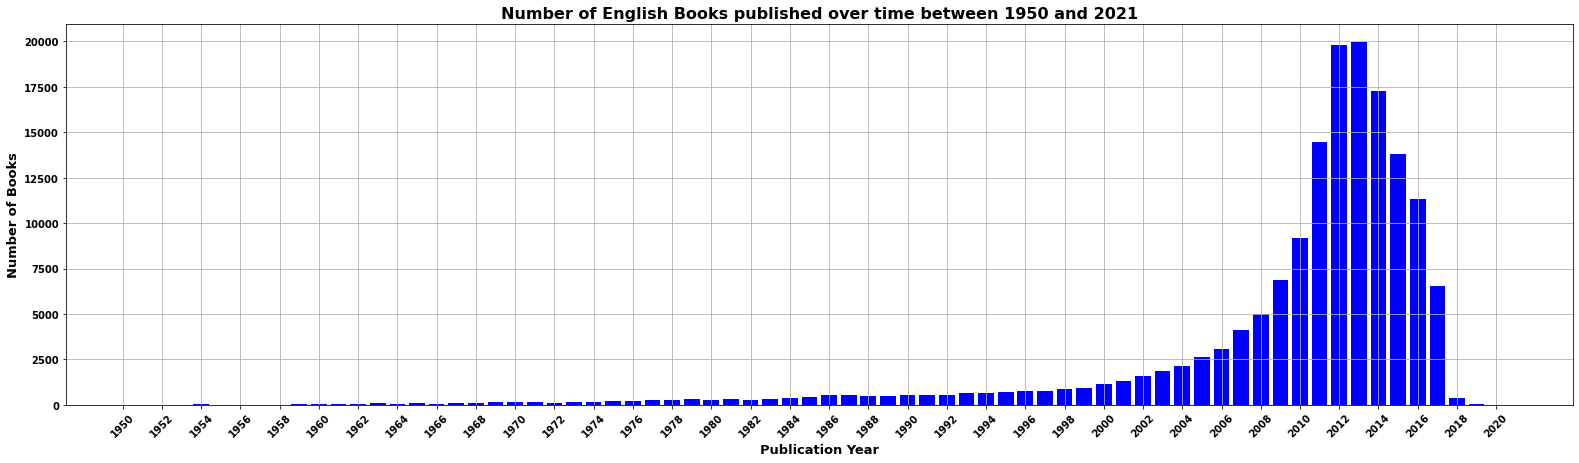

In [ ]:
plt.figure(figsize=(27, 7))
plt.bar(pubYear_bookFreq_info.loc[pubYear_bookFreq_info.pub_year_int>1950].pub_year_int.values, pubYear_bookFreq_info.loc[pubYear_bookFreq_info.pub_year_int>1950].num_books, color="blue", linewidth=3)
plt.xticks(np.arange(1950, 2021, 2), rotation=45)
plt.xlabel("Publication Year", fontweight="bold", fontsize=13)
plt.ylabel("Number of Books", fontweight="bold", fontsize=13)
plt.grid("brown")
plt.title("Number of English Books published over time between 1950 and 2021", fontweight="bold", fontsize=16)

plt.show()

### **Rating information**

In [ ]:
ratings = reviews_df.groupby("rating").count()[["book_id"]].reset_index().rename(columns={"book_id": "num_books"})
ratings

,rating,num_books
0,0,29782
1,1,28461
2,2,69639
3,3,197257
4,4,332077
5,5,342786


#### **We have more books with best review and less number of books with bad ratings**

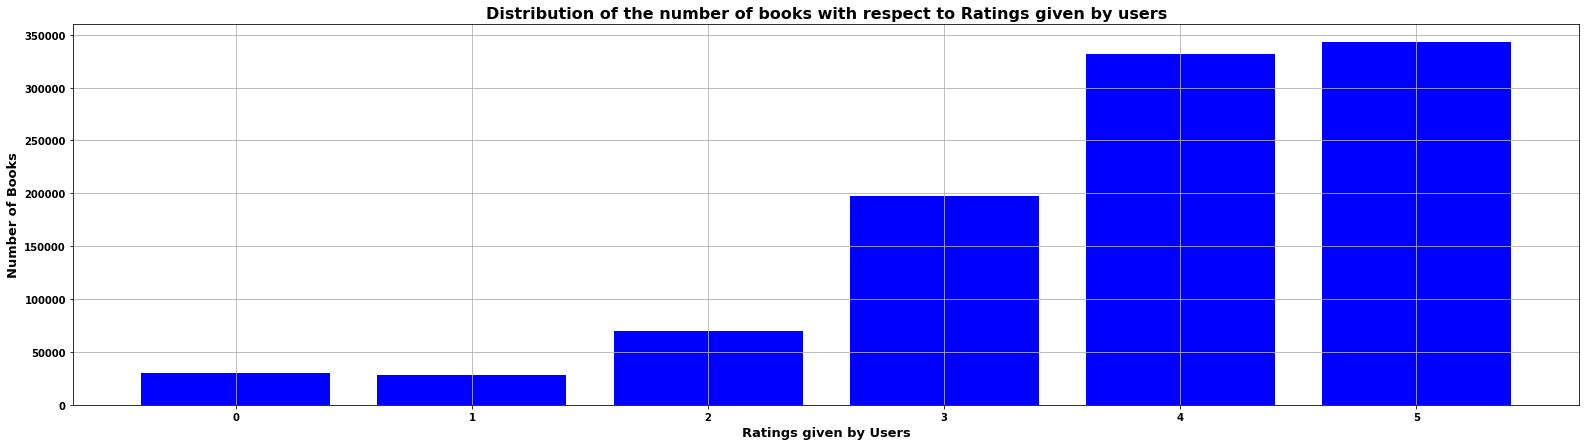

In [ ]:
plt.figure(figsize=(27, 7))
plt.bar(x=ratings.rating.values, height=ratings.num_books, color="blue")
#plt.xticks(np.arange(1950, 2021, 2), rotation=45)
plt.xlabel("Ratings given by Users", fontweight="bold", fontsize=13)
plt.ylabel("Number of Books", fontweight="bold", fontsize=13)
plt.grid("brown")
plt.title("Distribution of the number of books with respect to Ratings given by users", fontweight="bold", fontsize=16)

plt.show()